In [3]:
# Importing Libraries\n
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import os
from sklearn.metrics import r2_score
from scipy import stats
%matplotlib inline

In [4]:
"# Setting working directory\n",
os.chdir("C:/Users/Ankit singh/Downloads")
# Loading data\n,
df_train = pd.read_csv('train_cab.csv', parse_dates=["pickup_datetime"])
df_test =  pd.read_csv('test.csv',parse_dates=["pickup_datetime"])

In [5]:
df_train['pickup_datetime']  = pd.to_datetime(df_train['pickup_datetime'],errors='coerce')
df_test['pickup_datetime']  = pd.to_datetime(df_test['pickup_datetime'],errors='coerce')
data = [df_train,df_test]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day_of_Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

# Missing value analysis

In [6]:
#Print missing values

print(df_train.isnull().sum())



fare_amount          24
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
Year                  1
Month                 1
Date                  1
Day_of_Week           1
Hour                  1
dtype: int64


In [7]:
#As there are less than 5% of missing values,we can drop those rows instead of imputing as it wnt impact our training model
df_train=df_train.dropna()

# EDA and Outlier Analysis

In [8]:
df_train.dtypes

fare_amount                       object
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
Year                             float64
Month                            float64
Date                             float64
Day_of_Week                      float64
Hour                             float64
dtype: object

In [9]:
df_train['fare_amount'] = pd.to_numeric(df_train['fare_amount'],errors="coerce")
df_train['passenger_count']= df_train['passenger_count'].astype(int)

for col in ['Year', 'Month', 'Date', 'Day_of_Week', 'Hour']:
    df_train[col]= df_train[col].astype(int).astype('category')
    df_test[col]= df_test[col].astype(int).astype('category')


C:\Users\Ankit singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ankit singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ankit singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [10]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15986.000000,15987.000000,15987.000000,15987.000000,15987.000000,15987.000000
mean,15.030453,-72.464446,39.915630,-72.464004,39.898726,2.623131
std,431.213944,10.573270,6.828818,10.569932,6.186185,60.890129
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992143,40.734935,-73.991182,40.734651,1.000000
50%,8.500000,-73.981689,40.752603,-73.980167,40.753557,1.000000
75%,12.500000,-73.966819,40.767358,-73.963644,40.768008,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [11]:
# Min fare should be $2.5 and maximum cant exceed $500
df_train= df_train[(df_train.fare_amount>2.5)&(df_train.fare_amount<400)]

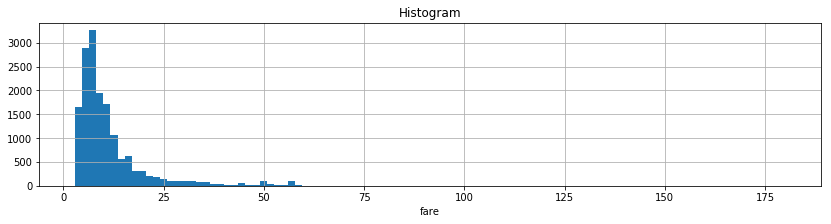

In [12]:
#Histogrm of Fare amount
df_train.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare')
plt.title('Histogram');

#Most of the expenses are less than 100, remaing seems outliers . We will analyze them further while comparing them with distance

In [13]:
# Analyzing passenger count
df_train['passenger_count'].value_counts()

1       11176
2        2316
5        1039
3         672
4         327
6         301
0          57
53          2
43          2
354         1
456         1
536         1
345         1
537         1
58          1
535         1
554         1
87          1
531         1
5345        1
236         1
5334        1
557         1
35          1
Name: passenger_count, dtype: int64

In [14]:
df_test['passenger_count'].value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

In [15]:
# Generally a cab cant accomodate more than 6 people.Additionally, these are just one instances for each passenger count >6 , so we can remove those rows. 
# Additionally the test data destn have passenegr countas 0, so we can drop them
df_train=df_train[(df_train.passenger_count<=6) & (df_train.passenger_count>0)]

In [16]:
# Analyzing latitude nd longitude
# Visulaizing the coordinates on map

# load image of NYC map
COOR = (-74.5, -72.8, 40.5, 41.8)
nyc = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
def plot_map(df, COOR, nyc, alpha):
    fig, graph= plt.subplots(1, 2, figsize=(16,10))
    graph[0].scatter(df.pickup_longitude, df.pickup_latitude,  alpha=alpha, c='r')
    graph[0].set_xlim((COOR[0], COOR[1]))
    graph[0].set_ylim((COOR[2], COOR[3]))
    graph[0].set_title('Pickup locations')
    graph[0].imshow(nyc,  extent=COOR)

    graph[1].scatter(df.dropoff_longitude, df.dropoff_latitude, alpha=alpha, c='r')
    graph[1].set_xlim((COOR[0], COOR[1]))
    graph[1].set_ylim((COOR[2], COOR[3]))
    graph[1].set_title('Dropoff locations')
    graph[1].imshow(nyc, extent=COOR)

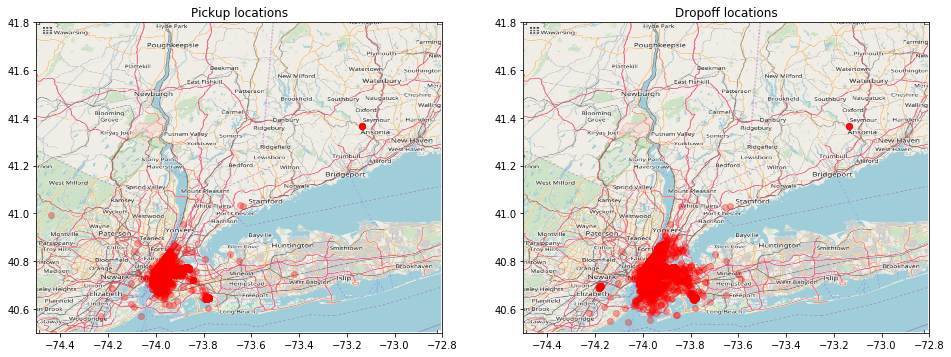

In [17]:
# plot training data on map
plot_map(df_train, COOR, nyc, alpha=0.3)

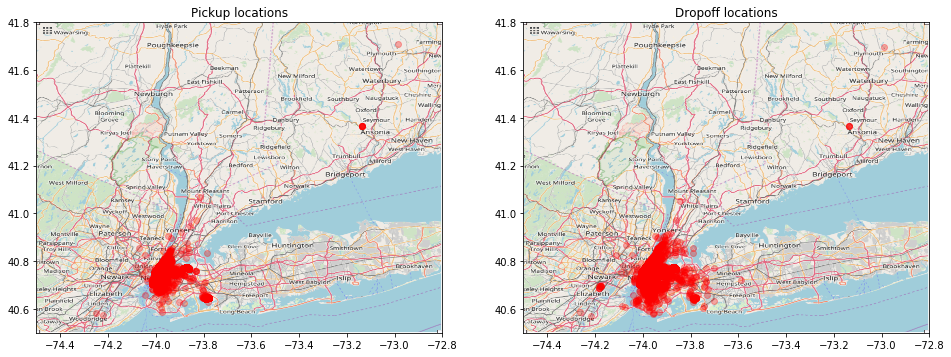

In [18]:
# plot test data on map
plot_map(df_test, COOR, nyc, alpha=0.3)

In [19]:
# Next we need to look at longitude and lattitude. I decide to exclude all those lattiude and longitude which are outsde the range of test data

#Range of longitude 
LONG=min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()),max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

In [20]:
# Range of latitude
LAT=min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()),max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

In [21]:
df_train=df_train[(df_train.pickup_latitude<LAT[1]) & (df_train.pickup_latitude>LAT[0])]
df_train=df_train[(df_train.dropoff_latitude<LAT[1]) & (df_train.dropoff_latitude>LAT[0])]
df_train=df_train[(df_train.pickup_longitude<LONG[1]) & (df_train.pickup_longitude>LONG[0])]
df_train=df_train[(df_train.dropoff_longitude<LONG[1]) & (df_train.dropoff_longitude>LONG[0])]


In [22]:
# Also, we can see there are lots of corridinates in water. 
from global_land_mask import globe
df_train['pickup_land']=globe.is_land(df_train.pickup_latitude,df_train.pickup_longitude)
df_train['drop_land']=globe.is_land(df_train.dropoff_latitude,df_train.dropoff_longitude)
df_test['pickup_land']=globe.is_land(df_test.pickup_latitude,df_test.pickup_longitude)
df_test['drop_land']=globe.is_land(df_test.dropoff_latitude,df_test.dropoff_longitude)

In [23]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# Returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p =  np.pi/180
    d = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(d)) 

In [24]:
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude,df_train.dropoff_latitude, df_train.dropoff_longitude)

In [25]:
df_test['distance_miles'] = distance(df_test.pickup_latitude, df_test.pickup_longitude,df_test.dropoff_latitude, df_test.dropoff_longitude)

In [26]:
df_train.distance_miles.describe()

count    15497.000000
mean         2.097264
std          2.513438
min          0.000000
25%          0.785211
50%          1.352712
75%          2.426204
max         62.817285
Name: distance_miles, dtype: float64

In [27]:
df_test.distance_miles.describe()


 

count    9914.000000
mean        2.134640
std         2.468319
min         0.000000
25%         0.806712
50%         1.377836
75%         2.513634
max        62.134660
Name: distance_miles, dtype: float64

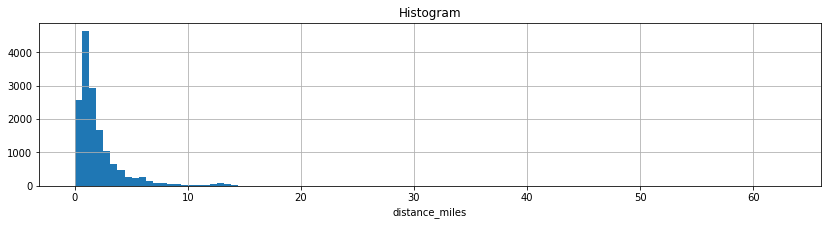

In [28]:
df_train.distance_miles.hist(bins=100, figsize=(14,3))
plt.xlabel('distance_miles')
plt.title('Histogram');

Text(0, 0.5, 'Fare')

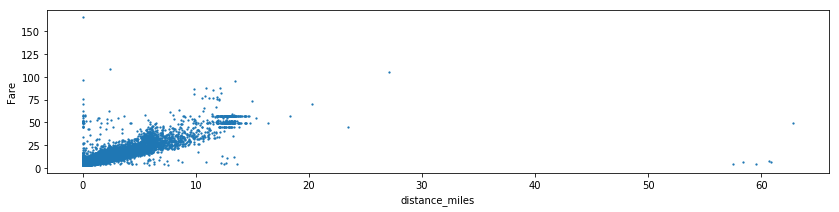

In [29]:
plt.figure(figsize=(14,3))
plt.scatter(x=df_train['distance_miles'], y=df_train['fare_amount'], s=1.5)
plt.xlabel('distance_miles')
plt.ylabel('Fare')

In [30]:
# Distance could be 0 due to cancellation of trip resulitng in cancellation charges or some noise. Assuming the first case, I have taken the average of all costs ot be put as cancellation charges.
df_train['fare_amount'][df_train['distance_miles']==0]=np.mean(df_train['fare_amount'][df_train['distance_miles']==0])

C:\Users\Ankit singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
# For higher distance ( around 60 kms), we see that expenses are quite low which doesnt seem reasonable. Thus, we have imputet the fare amount
df_train['fare_amount'].loc[df_train['distance_miles']>50 ]= np.nan
df_train.isnull().sum()

from fancyimpute import KNN
df_train=df_train.drop("pickup_datetime", axis=1)
df_train = pd.DataFrame(KNN(k = 3).fit_transform(df_train),columns=df_train.columns)

C:\Users\Ankit singh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Imputing row 1/15497 with 0 missing, elapsed time: 584.235
Imputing row 101/15497 with 0 missing, elapsed time: 591.078
Imputing row 201/15497 with 0 missing, elapsed time: 591.172
Imputing row 301/15497 with 0 missing, elapsed time: 591.218
Imputing row 401/15497 with 0 missing, elapsed time: 591.281
Imputing row 501/15497 with 0 missing, elapsed time: 591.297
Imputing row 601/15497 with 0 missing, elapsed time: 591.451
Imputing row 701/15497 with 0 missing, elapsed time: 591.498
Imputing row 801/15497 with 0 missing, elapsed time: 592.495
Imputing row 901/15497 with 0 missing, elapsed time: 592.635
Imputing row 1001/15497 with 0 missing, elapsed time: 592.758
Imputing row 1101/15497 with 0 missing, elapsed time: 593.227
Imputing row 1201/15497 with 0 missing, elapsed time: 593.601
Imputing row 1301/15497 with 0 missing, elapsed time: 594.114
Imputing row 1401/15497 with 0 missing, elapsed time: 594.224
Imputing row 1501/15497 with 0 missing, elapsed time: 594.224
Imputing row 1601/15

In [33]:
df_train.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day_of_Week          0
Hour                 0
pickup_land          0
drop_land            0
distance_miles       0
dtype: int64

In [34]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day_of_Week,Hour,pickup_land,drop_land,distance_miles
count,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000,15497.000000
mean,11.348142,-73.974874,40.751348,-73.973859,40.751927,1.651675,2011.736788,6.270827,15.665742,3.034910,13.504807,0.997806,0.996709,2.097264
std,9.480880,0.040367,0.030966,0.038835,0.033272,1.266801,1.869921,3.447710,8.683771,1.969929,6.506906,0.046790,0.057274,2.513438
min,2.900000,-74.229138,40.572183,-74.227047,40.574652,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992385,40.736687,-73.991372,40.736437,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.000000,1.000000,0.785211
50%,8.500000,-73.982074,40.753389,-73.980572,40.754257,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,1.000000,1.000000,1.352712
75%,12.500000,-73.968137,40.767807,-73.965505,40.768332,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,1.000000,1.000000,2.426204
max,165.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,1.000000,1.000000,62.817285


Text(0, 0.5, 'Frequency')

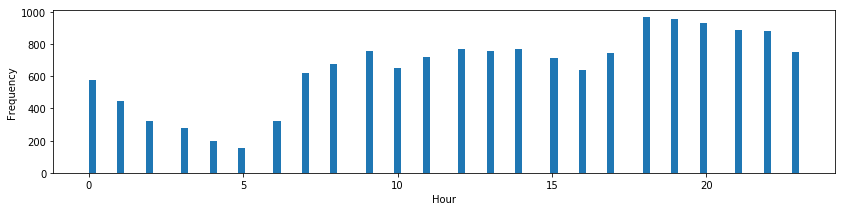

In [35]:
plt.figure(figsize=(14,3))
plt.hist(df_train['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')


In [36]:
df_train['session']=pd.cut(df_train.Hour,[-1,4,12,17,24],labels=[0,1,2,3])
df_test['session']=pd.cut(df_test.Hour,[-1,4,12,17,24],labels=[0,1,2,3])

Text(0, 0.5, 'Frequency')

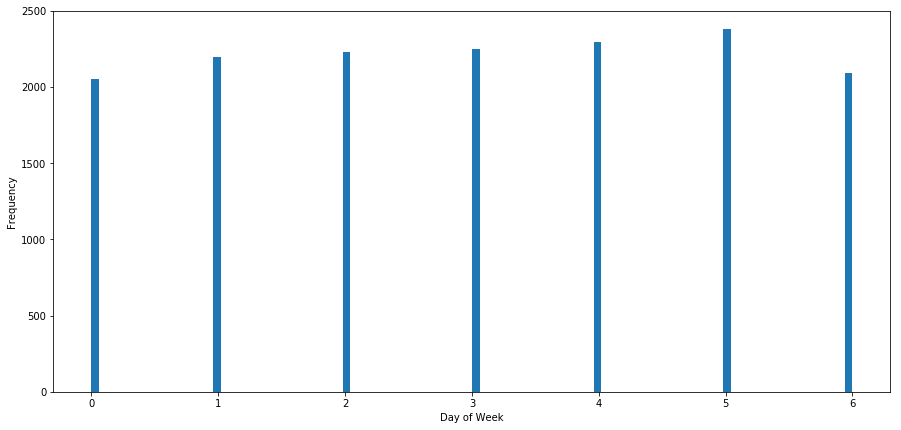

In [37]:

plt.figure(figsize=(15,7))
plt.hist(df_train['Day_of_Week'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

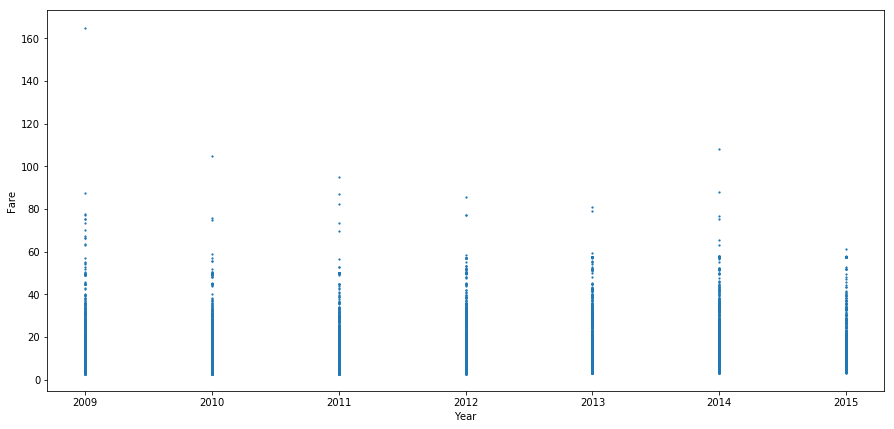

In [38]:

plt.figure(figsize=(15,7))
plt.scatter(x=df_train['Year'], y=df_train['fare_amount'], s=1.5)
plt.xlabel('Year')
plt.ylabel('Fare')

In [39]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, 
lgr = (-73.87, 40.77) # LaGuardia Airport
jfk = (-73.7822222222, 40.6441666667)
df_train['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
df_train['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
df_train['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [40]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, 
lgr = (-73.87, 40.77) # LaGuardia Airport
jfk = (-73.7822222222, 40.6441666667)
df_test['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_test.pickup_latitude, df_test.pickup_longitude)
df_test['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_test.pickup_latitude, df_test.pickup_longitude)
df_test['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_test.pickup_latitude, df_test.pickup_longitude)
df_test['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_test.dropoff_latitude, df_test.dropoff_longitude)

Text(0, 0.5, 'Fare')

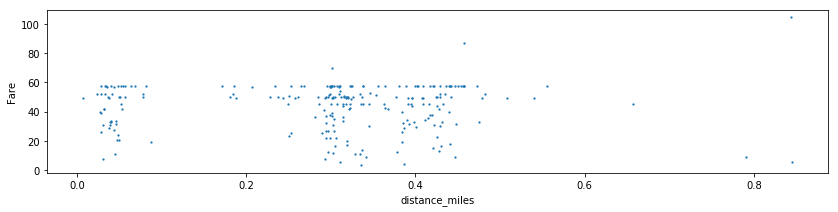

In [42]:
plt.figure(figsize=(14,3))
plt.scatter(x=df_train['pickup_distance_to_jfk'][df_train['pickup_distance_to_jfk']<1], y=df_train['fare_amount'][df_train['pickup_distance_to_jfk']<1], s=1.5)
plt.xlabel('distance_miles')
plt.ylabel('Fare')

Text(0, 0.5, 'Fare')

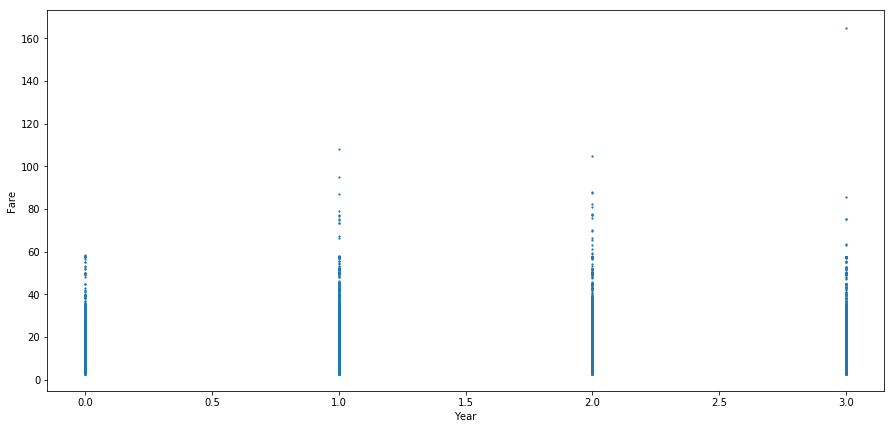

In [44]:
plt.figure(figsize=(15,7))
plt.scatter(x=df_train['session'], y=df_train['fare_amount'], s=1.5)
plt.xlabel('Year')
plt.ylabel('Fare')

# Feature importance

In [45]:
df=df_train.copy()

In [46]:
cont=["fare_amount", "distance_miles",'pickup_distance_to_jfk',
       'dropoff_distance_to_jfk', 'pickup_distance_to_ewr',
       'dropoff_distance_to_ewr', 'pickup_distance_to_lgr',
       'dropoff_distance_to_lgr']
cat= ['Year','Month', 'Date', 'Day_of_Week', 'Hour','pickup_land', 'drop_land','session',"passenger_count"]

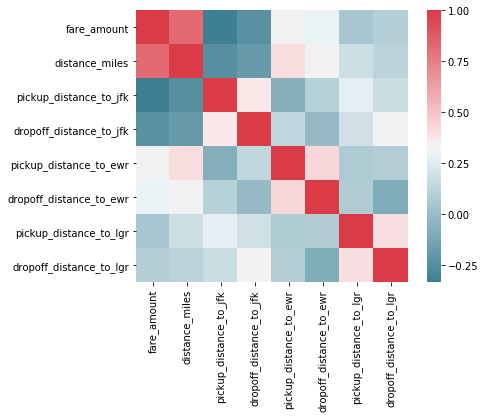

In [47]:
df_corr = df.loc[:,cont]

#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)#

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

y = 'fare_amount'
for  i in cat:
    c = y + ' ~ ' + i
    model = ols(c,data=df_train).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    print(anova)

                sum_sq       df           F        PR(>F)
Year      1.698414e+04      1.0  191.269758  3.034502e-43
Residual  1.375906e+06  15495.0         NaN           NaN
                sum_sq       df          F        PR(>F)
Month     2.365271e+03      1.0  26.356859  2.872450e-07
Residual  1.390525e+06  15495.0        NaN           NaN
                sum_sq       df         F    PR(>F)
Date      6.107818e+01      1.0  0.679485  0.409777
Residual  1.392829e+06  15495.0       NaN       NaN
                   sum_sq       df         F    PR(>F)
Day_of_Week  1.434349e+00      1.0  0.015956  0.899482
Residual     1.392889e+06  15495.0       NaN       NaN
                sum_sq       df          F    PR(>F)
Hour      1.311439e+03      1.0  14.602656  0.000133
Residual  1.391579e+06  15495.0        NaN       NaN
                   sum_sq       df         F    PR(>F)
pickup_land  5.146342e+02      1.0  5.727088  0.016717
Residual     1.392376e+06  15495.0       NaN       NaN
          

In [51]:
df_train = df_train.drop(['Date','Day_of_Week','passenger_count','pickup_longitude', 'pickup_latitude',
      'dropoff_longitude', 'dropoff_latitude'], axis=1)
df_test = df_test.drop(['Date','Day_of_Week','pickup_datetime','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'], axis=1)
df_train = df_train.drop(['pickup_land','drop_land'], axis=1)

df_test = df_test.drop(['pickup_land','drop_land'], axis=1)

In [52]:
cat= ['Year','Month', 'Hour','session']

# Feature scaling

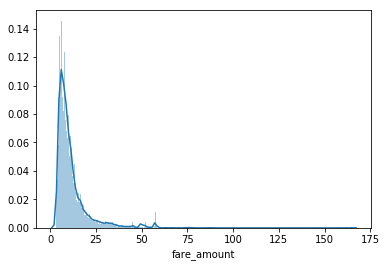

In [48]:
#Normality check
%matplotlib inline  
#for i in cont:
sns.distplot(df_train['fare_amount'], bins='auto')
plt.show()

# Modelling

In [53]:
# Using train_test_split sampling function for test and train data split
#Seperating out target and predictor
X= df_train.drop(['fare_amount'],axis=1)
y= df_train['fare_amount']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Model development
LR_model = LinearRegression().fit(X_train , y_train)

# Predicting our variable for train and test
LR_train = LR_model.predict(X_train)
LR_test = LR_model.predict(X_test)


# Calculatng important metrix
RMSE_train = np.sqrt(mean_squared_error(y_train,LR_train))
RMSE_test =np.sqrt(mean_squared_error(y_test,LR_test))
R_square=r2_score(y_test,LR_test)

#SHowing the output
print("RMSE_Train = "+str(RMSE_train))
print("RMSE_test = "+str(RMSE_test))
print("R^2 Score = "+str(R_square))

RMSE_Train = 4.950973045742593
RMSE_test = 5.031167321882907
R^2 Score = 0.6876443168677395


In [55]:
# Libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Model development
DT_model = DecisionTreeRegressor(max_depth = 2).fit(X_train,y_train)

# Predicting our variable for train and test
DT_train = DT_model.predict(X_train)
DT_test = DT_model.predict(X_test)


# Calculatng important metrix
RMSE_train = np.sqrt(mean_squared_error(y_train,DT_train))
RMSE_test =np.sqrt(mean_squared_error(y_test,DT_test))
R_square=r2_score(y_test,DT_test)

#SHowing the output
print("RMSE_Train = "+str(RMSE_train))
print("RMSE_test = "+str(RMSE_test))
print("R^2 Score = "+str(R_square))

RMSE_Train = 5.005391350682308
RMSE_test = 4.743561572420049
R^2 Score = 0.7223351056585124


In [56]:
# Libraries
from sklearn.ensemble import RandomForestRegressor

# Model development
RF_model = RandomForestRegressor(n_estimators = 500).fit(X_train,y_train)

# Predicting our variable for train and test
RF_train = RF_model.predict(X_train)
RF_test = RF_model.predict(X_test)


# Calculatng important metrix
RMSE_train = np.sqrt(mean_squared_error(y_train,RF_train))
RMSE_test =np.sqrt(mean_squared_error(y_test,RF_test))
R_square=r2_score(y_test,RF_test)

#SHowing the output
print("RMSE_Train = "+str(RMSE_train))
print("RMSE_test = "+str(RMSE_test))
print("R^2 Score = "+str(R_square))

RMSE_Train = 1.4989806741963758
RMSE_test = 3.7483443900595614
R^2 Score = 0.8266232480971039


In [57]:
# Libraries
from sklearn.ensemble import GradientBoostingRegressor

# Model_development
GB_model = GradientBoostingRegressor().fit(X_train, y_train)

# Predicting our variable for train and test
GB_train = GB_model.predict(X_train)
GB_test = GB_model.predict(X_test)


# Calculatng important metrix
RMSE_train = np.sqrt(mean_squared_error(y_train,GB_train))
RMSE_test =np.sqrt(mean_squared_error(y_test,GB_test))
R_square=r2_score(y_test,GB_test)

#SHowing the output
print("RMSE_Train = "+str(RMSE_train))
print("RMSE_test = "+str(RMSE_test))
print("R^2 Score = "+str(R_square))

RMSE_Train = 3.192024130413634
RMSE_test = 3.7172870962232056
R^2 Score = 0.8294844074721865


In [58]:
# Cross validation
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
cv_r2_score=cross_val_score(GB_model, X_train,y_train, cv=5, scoring='r2')
print(cv_r2_score)


[0.82860156 0.75105955 0.83215172 0.84062485 0.88377897]


In [60]:
N=GB_model.predict(df_test)

In [61]:
df_test['Fare_amount']=N

Text(0, 0.5, 'Fare')

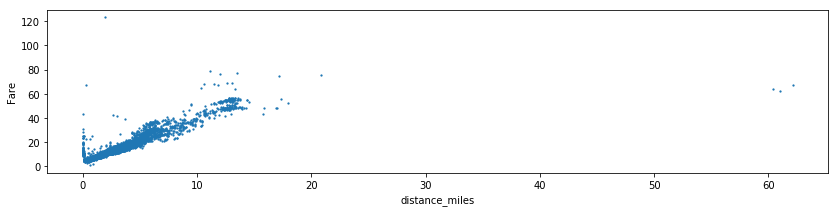

In [62]:
plt.figure(figsize=(14,3))
plt.scatter(x=df_test['distance_miles'], y=df_test['Fare_amount'], s=1.5)
plt.xlabel('distance_miles')
plt.ylabel('Fare')